In [1]:
%load_ext lab_black

In [2]:
import contextlib
import itertools
from pathlib import Path
from types import SimpleNamespace
import functools
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.infer.autoguide as ag
import pyro.poutine as poutine

import bayesrul.dependencies.tyxe as tyxe

from tqdm.auto import trange

from bayesrul.ncmapss.dataset import NCMAPSSDataModule
from bayesrul.ncmapss.frequentist_models import NCMAPSSModel

In [7]:
pyro.set_rng_seed(42)

args = SimpleNamespace(
    data_path="../data/ncmapss",
    out_path="../results/ncmapss",
    study="bnn_tyxe_mfi",
    net="linear",
    lr=1e-3,
    inference="mfi",
    device=torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu"),
)
args.fit_ctxt = (
    contextlib.nullcontext
    if args.inference == "ml"
    else tyxe.poutine.local_reparameterization
)  # tyxe.poutine.flipout
results_dir = Path(f"{args.out_path}/{args.study}/{args.net}")
results_dir.mkdir(parents=True, exist_ok=True)


def define_model(data, ll_scale, guide_init_scale, args):
    model = NCMAPSSModel(
        data.win_length, data.n_features, archi=args.net, activation="tanh"
    ).to(args.device)
    # model = nn.Sequential(
    #     nn.Flatten(),
    #     nn.Linear(data.win_length * data.n_features, 256),
    #     nn.ReLU(),
    #     nn.Linear(256, 128),
    #     nn.ReLU(),
    #     nn.Linear(128, 128),
    #     nn.ReLU(),
    #     nn.Linear(128, 32),
    #     nn.ReLU(),
    #     nn.Linear(32, 2),
    #     nn.Sigmoid()
    #     # nn.Softplus(),
    # ).to(args.device)
    prior_kwargs = dict(
        hide_all=args.inference == "ml"
    )  # , hide_module_types=(nn.BatchNorm2d,))
    prior = tyxe.priors.IIDPrior(
        dist.Normal(
            torch.tensor(0.0, device=args.device),
            torch.tensor(1, device=args.device),
        ),
        **prior_kwargs,
    )
    # likelihood = tyxe.likelihoods.HomoskedasticGaussian(
    #     data.train_size,
    #      scale=ll_scale,
    # )
    likelihood = tyxe.likelihoods.HeteroskedasticGaussian(
        data.train_size, positive_scale=True, event_dim=1
    )
    guide = (
        partial(tyxe.guides.AutoNormal, init_scale=guide_init_scale)
        if args.inference != "ml"
        else None
    )
    return tyxe.VariationalBNN(model, prior, likelihood, guide)

In [14]:
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from bayesrul.dependencies.tyxe.bnn import _to


def fit(
    self,
    data_loader,
    optim,
    num_epochs,
    callback=None,
    num_particles=1,
    closed_form_kl=True,
    device=None,
    loss=None,
):
    old_training_state = self.net.training
    self.net.train(True)

    if loss is None:
        loss = (
            TraceMeanField_ELBO(num_particles)
            if closed_form_kl
            else Trace_ELBO(num_particles)
        )

    svi = SVI(self.model, self.guide, optim, loss=loss)

    for i in range(num_epochs):
        elbo = 0.0
        num_batch = 1
        for num_batch, (input_data, observation_data) in enumerate(
            iter(data_loader), 1
        ):
            elbo += svi.step(
                tuple(_to(input_data, device)),
                tuple(_to(observation_data.unsqueeze(-1), device))[0],
            )

        # the callback can stop training by returning True
        if callback is not None and callback(self, i, elbo / num_batch):
            break

    self.net.train(old_training_state)
    return svi

In [15]:
data = NCMAPSSDataModule(args.data_path, batch_size=1000)
bnn = define_model(data, ll_scale=0.2543, guide_init_scale=2e-9, args=args)
train_dl = data.train_dataloader()
val_dl = data.val_dataloader()

pyro.clear_param_store()
elbos, errors, lls = [], [], []

if Path(f"{results_dir}/param_store.pt").exists():
    pyro.get_param_store().load(f"{results_dir}/param_store.pt")
    elbos = np.load(f"{results_dir}/elbos.npy").tolist()
    errors = np.load(f"{results_dir}/errors.npy").tolist()

max_epochs = 1
num_epochs = max_epochs - len(elbos)

# optim= pyro.optim.SGD({"lr": 1e-5, "momentum":0.9})
# optim = pyro.optim.Adam({"lr": 1e-3, "betas": (0.90, 0.999)})
# optim = pyro.optim.Adam({"lr": 1e-3})
optim = pyro.optim.MultiStepLR(
    {
        "optimizer": torch.optim.Adam,
        "optim_args": {"lr": 1e-4, "betas": (0.90, 0.999)},
        "milestones": [10, 20],
        "gamma": 0.1,
    }
)
# gamma = 0.1
# lrd = gamma ** (1 / max_epochs)
# optim = pyro.optim.ClippedAdam({"lr": 1e-4, "lrd": lrd})

pbar = trange(len(elbos), max_epochs)


def callback(bnn, epoch, avg_elbo):
    avg_err, avg_ll = 0.0, 0.0
    for x, y in val_dl:
        err, ll = bnn.evaluate(x.to(args.device), y.to(args.device).view(-1,1), num_predictions=2)
        # print(err, ll)
        avg_err += err / len(val_dl.sampler)
        avg_ll += ll / len(val_dl.sampler)
    if epoch % 1 == 0:
        print(
            f"EPOCH={epoch}; ELBO={avg_elbo:.3f}; test error={avg_err:.3f}; LL={avg_ll:.3f}"
        )
    elbos.append(avg_elbo)
    errors.append(avg_err.item())
    lls.append(avg_ll.item())
    pbar.update()


with args.fit_ctxt():
    fit(bnn, train_dl, optim, num_epochs, device=args.device, callback=callback)

pyro.get_param_store().save(f"{results_dir}/param_store.pt")
np.save(f"{results_dir}/elbos.npy", elbos)
np.save(f"{results_dir}/errors.npy", errors)

  0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: module 'pyro.infer.autoguide.guides' has no attribute '_deep_setattr'

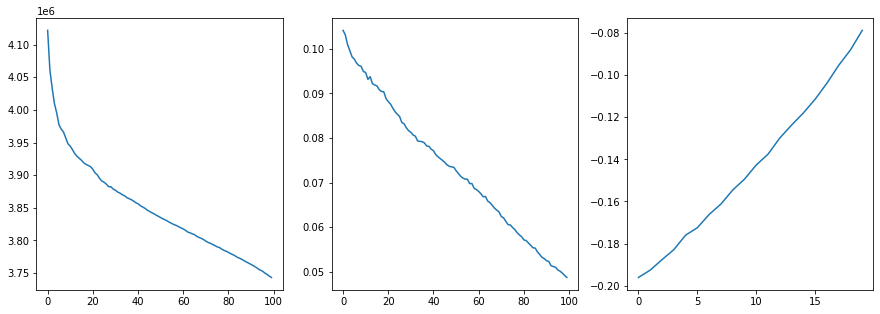

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(elbos)
ax[1].plot(errors)
ax[2].plot(lls)

### Test

In [26]:
data = NCMAPSSDataModule(args.data_path, batch_size=10000)
test_dl = data.test_dataloader()
# test_dl = data.train_dataloader()
# test_dl = DataLoader(
#     data.datasets["train"],
#     batch_size=10000,
#     shuffle=False,
#     num_workers=4,
#     pin_memory=True,
# )
#pyro.get_param_store().load(f"{results_dir}/param_store.pt")

In [27]:
with args.fit_ctxt():
    preds, stds, labels = [], [], []
    # for x, y in itertools.islice(test_dl, 2):
    for x, y in test_dl:
        pred, std = bnn.predict(
            x.to(args.device),
            num_predictions=1 if args.inference == "ml" else 10,
            aggregate=args.inference != "ml",
        ).chunk(2, dim=-1)
        preds.append(pred)
        stds.append(std)
        labels.append(y)
preds = torch.stack(preds[:-1]).view(-1).detach().cpu()
stds = torch.stack(stds[:-1]).view(-1).detach().cpu()
labels = torch.stack(labels[:-1]).view(-1).detach().cpu()

torch.save(preds, Path(f"{results_dir}/test_preds.pt"))
torch.save(stds, Path(f"{results_dir}/test_stds.pt"))
torch.save(labels, Path(f"{results_dir}/test_labels.pt"))

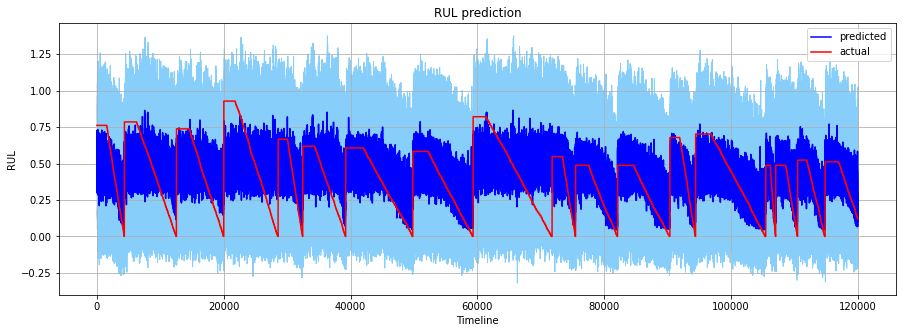

In [28]:
# MFI (linear with sigmoid and normalised outputs, 100 epochs)
n = len(preds)
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()
plt.plot(range(n), preds, color="blue", label="predicted")
plt.plot(range(n), labels, color="red", label="actual")
plt.fill_between(range(n), preds - stds, preds + stds, color="lightskyblue")
plt.title("RUL prediction")
plt.xlabel("Timeline")
plt.ylabel("RUL")
plt.grid()
plt.legend()

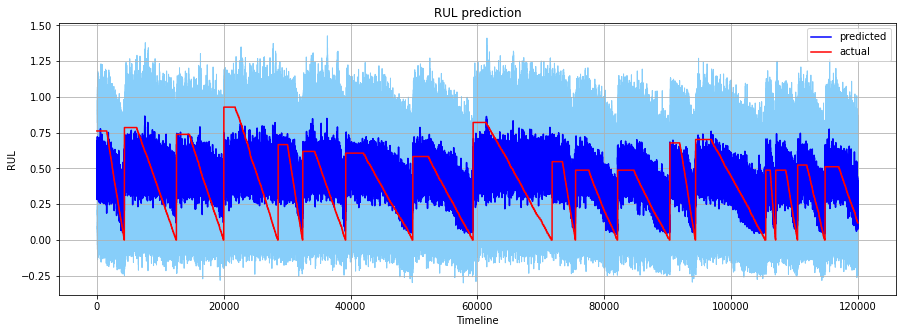

In [25]:
# MFI (linear with sigmoid and normalised outputs, 100 epochs)
n = len(preds)
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()
plt.plot(range(n), preds, color="blue", label="predicted")
plt.plot(range(n), labels, color="red", label="actual")
plt.fill_between(range(n), preds - stds, preds + stds, color="lightskyblue")
plt.title("RUL prediction")
plt.xlabel("Timeline")
plt.ylabel("RUL")
plt.grid()
plt.legend()

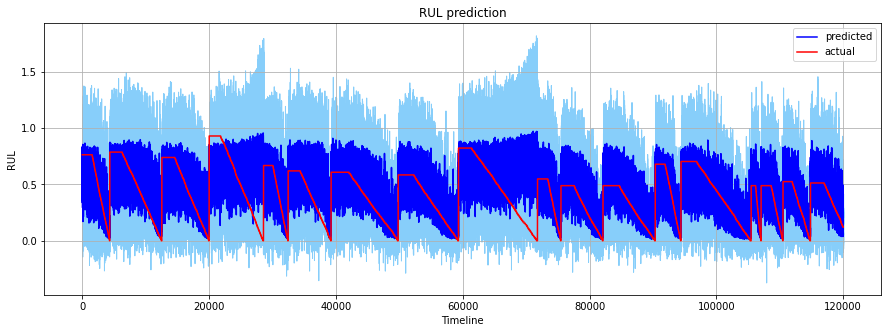

In [ ]:
# MLE
n = len(preds)
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()
plt.plot(range(n), preds, color="blue", label="predicted")
plt.plot(range(n), labels, color="red", label="actual")
plt.fill_between(range(n), preds - stds, preds + stds, color="lightskyblue")
plt.title("RUL prediction")
plt.xlabel("Timeline")
plt.ylabel("RUL")
plt.grid()
plt.legend()